In [1]:
import pystan 
import arviz as az
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
rng = np.random.default_rng()

In [2]:
I0 = 0.02    # initial fraction infected
S0 = 1 - I0 # initial fraction susceptible
R0 = 0
y0 = np.array([S0, I0, R0])

# Assign transmission and pathogen-induced death rates:
beta = 0.25
gamma = 0.04
args = (beta, gamma)

# Create a time series over which to integrate.
# Here we have an epidemic that is observed over t_max number of days
t_min = 0
t_max = 100
t_eval = np.linspace(t_min, t_max, t_max) + 1 # one observation per day

In [3]:
def sir(t, y, beta, gamma):
    S, I, R = y
    dS = - beta * S * I
    dI = beta * S * I - gamma * I
    dR = gamma * I
    return np.array([dS, dI, dR])

In [4]:
# Run the integration:
out = solve_ivp(sir, (t_min, t_max+1), y0, t_eval=t_eval, args=args)

In [5]:
sample_n = 200 # number of host individuals sampled per day

# Generate binomially distributed data.
# So, on each day we sample a given number of people (sample_n), and measure how many are infected.
# We expect binomially distributed error in this estimate, hence the random number generation.
sample_y = rng.binomial(sample_n, out.y[1,:])

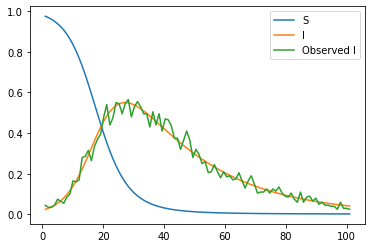

In [6]:
plt.plot(out.t, out.y[0,:], label="S")
plt.plot(out.t, out.y[1,:], label="I")
plt.plot(out.t, sample_y/sample_n, label="Observed I")
plt.legend()

In [7]:
sir_model = """
functions {
  
  real[] SI(real t, real[] y, real[] params, real[] x_r, int[] x_i) {
      
      real dydt[3];
      
      dydt[1] = - params[1] * y[1] * y[2];
      dydt[2] = params[1] * y[1] * y[2] - params[2] * y[2];
      dydt[3] = params[2] * y[2];
      
      return dydt;
    }
  
}

data {
  int<lower = 1> n_obs; // Number of days sampled
  int<lower = 1> n_params; // Number of model parameters
  int<lower = 1> n_difeq; // Number of differential equations in the system
  int<lower = 1> n_sample; // Number of hosts sampled at each time point.
  
  int y[n_obs]; // The binomially distributed data
  real t0; // Initial time point (zero)
  real ts[n_obs]; // Time points that were sampled
  
  //data not included in fit
  int<lower = 0> n_obs_ex;
  int y_ex[n_obs_ex];
  real ts_ex[n_obs_ex];

}

transformed data {
  real x_r[0];
  int x_i[0];
}

parameters {
  real<lower = 0> params[n_params]; // Model parameters
  real<lower = 0, upper = 1> S0; // Initial fraction of hosts susceptible
}

transformed parameters{
  real y_hat[n_obs, n_difeq]; // Output from the ODE solver
  real y0[n_difeq]; // Initial conditions for both S and I

  y0[1] = S0;
  y0[2] = 1 - S0;
  y0[3] = 0;
  
  y_hat = integrate_ode_rk45(SI, y0, t0, ts, params, x_r, x_i);
  
}

model {
  params ~ normal(0, 2); //constrained to be positive
  S0 ~ normal(0.5, 0.5); //constrained to be 0-1.
  
  for (i in 1:n_obs) {
      if (y_hat[i, 2] < 0) 
          target += binomial_lpmf(y[i]| n_sample, 0);
      else
          target += binomial_lpmf(y[i]| n_sample, y_hat[i, 2]);     
  }
  
}

generated quantities {
  // Generate predicted data over the whole time series:
  real lik[n_obs];
  real y_ex_hat[n_obs_ex, n_difeq];
  real lik_ex[n_obs_ex];
  
  
  for (i in 1:n_obs) {
      if (y_hat[i, 2] < 0) 
          lik[i] = binomial_lpmf(y[i]| n_sample, 0);
      else
          lik[i] = binomial_lpmf(y[i]| n_sample, y_hat[i, 2]);
  }
  if (n_obs_ex > 0) {
      y_ex_hat = integrate_ode_rk45(SI, y0, t0, ts_ex, params, x_r, x_i);
      for (j in 1:n_obs_ex) {
          if (y_ex_hat[j, 2] < 0) 
              lik_ex[j] = binomial_lpmf(y_ex[j]| n_sample, 0);
          else
              lik_ex[j] = binomial_lpmf(y_ex[j]| n_sample, y_ex_hat[j, 2]);
      }
  }

}
"""

In [8]:
stan_model = pystan.StanModel(model_code=sir_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c1dc9ab1a5d27e9f02188db722d212d8 NOW.


In [9]:
def split_data_dict(n_obs, t_max=t_max, t_eval=t_eval, sample_y=sample_y):
    # split between "known" data and data to predict
    #n_obs = 30
    n_obs_ex = t_max - n_obs
    ts = t_eval[:n_obs]
    ts_ex = t_eval[n_obs:]
    y = sample_y[:n_obs]
    y_ex = sample_y[n_obs:]

    # define dict with data
    stan_data = dict(
        n_obs = n_obs,
        n_params = len(args),
        n_difeq = len(y0),
        n_sample = sample_n,
        y = y,
        t0 = 0,
        ts = ts,
        # data not taken into account for fit
        n_obs_ex = n_obs_ex,
        y_ex = y_ex,
        ts_ex = ts_ex,
    )
    return stan_data
stan_data = split_data_dict(100)

In [10]:
sample_kwargs = {"iter": 1000, "chains": 4, "control": {"adapt_delta": 0.95}}
fit = stan_model.sampling(data=stan_data, **sample_kwargs)

In [11]:
dims = {
    "params": ["param"], 
    "y_postpred": ["day"], 
    "lik": ["day"], 
    "y_hat": ["day", "group"], 
    "y": ["day"],
    "y0": ["group"],
    "ts": ["day"],
    "y_ex": ["day_ex"],
    "ts_ex": ["day_ex"],
}
coords = {
    "param": ["beta", "gamma"], 
    "group": ["S", "I", "R"],
}
idata_kwargs = {
    "observed_data": ["y", "y_ex"],
    "constant_data": ["ts", "ts_ex"],
    "log_likelihood": {"y": "lik", "y_ex": "lik_ex"},
    "dims": dims,
    "coords": coords,
}
idata = az.from_pystan(posterior=fit, **idata_kwargs)

In [12]:
az.summary(idata, var_names="~^y", filter_vars="regex")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
params[0],0.242,0.006,0.232,0.254,0.0,0.0,847.0,846.0,843.0,919.0,1.00
params[1],0.040,0.001,0.039,0.041,0.0,0.0,1076.0,1075.0,1074.0,939.0,1.01
S0,0.978,0.002,0.974,0.982,0.0,0.0,896.0,896.0,893.0,854.0,1.00


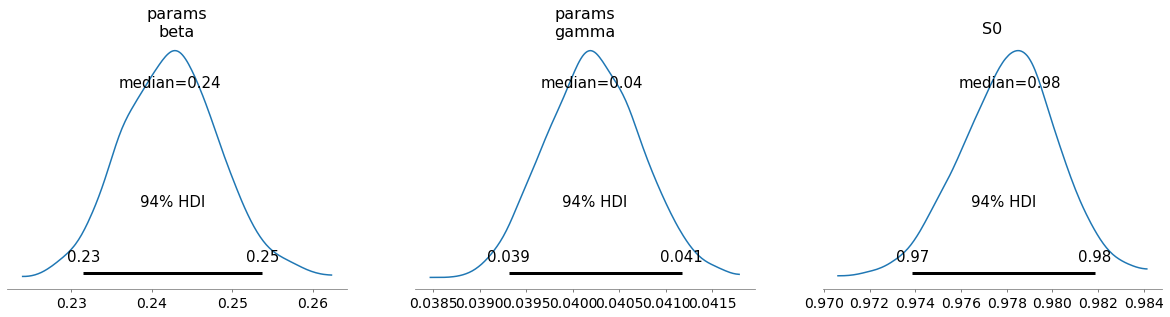

In [13]:
az.plot_posterior(idata, var_names="~^y", filter_vars="regex");

In [14]:
loo = az.loo(idata, var_name="y", pointwise=True)
loo

Computed from 2000 by 100 log-likelihood matrix

         Estimate       SE
elpd_loo  -303.27     6.77
p_loo        3.17        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [16]:
elpd_loo = loo.loo_i.sel(day=np.arange(30, 99)).values
print(f"elpd_loo   : {elpd_loo.sum()}\nelpd_loo_se: {(len(np.arange(30, 99))*np.var(elpd_loo))**.5}")

elpd_loo   : -205.02338725676816
elpd_loo_se: 5.289199775852263


## Exact one step ahead cross validation
Refit the model including from 30 to 99 observations.

In [49]:
from arviz.stats.stats_utils import logsumexp

In [53]:
splits = np.arange(30, 99)
elpd_lfo = np.empty(len(splits))
for idx, split_id in enumerate(splits):
    stan_data = split_data_dict(split_id)
    fit = stan_model.sampling(data=stan_data, **sample_kwargs)
    idata = az.from_pystan(posterior=fit, **idata_kwargs)
    elpd_lfo[idx] = np.exp(
        idata.log_likelihood.y_ex.isel(day_ex=0).stack(sample=("chain", "draw"))
    ).mean().item()
elpd_lfo.sum()

3.9747056571323434

In [58]:
elpd_lfo = np.log(elpd_lfo)
print(f"elpd_lfo   : {elpd_lfo.sum()}\nelpd_lfo_se: {(len(splits)*np.var(elpd_lfo))**.5}")

elpd_lfo   : -210.54626842098617
elpd_lfo_se: 5.999860267422607
